## Import libraries, methods and constants

In [1]:
import numpy as np
from PIL import Image
import datasets
import json
import json
import torch
import codecs
import matplotlib.pyplot as plt
import os
from os import sys

c:\Users\kuian\.conda\envs\master\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
from data_prepossessing import create_datasets_for_plants, get_labels
from data_visualization import visualize_annotation, visualize_annotation_for_image
from constants import crop_indices, weed_indices, weed_plants, weed_plants, color_values, hex_colors, plant_classification
from config import model_types, crops, model_type, crop
from data_visualization import get_legend

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
print(device)

cpu


In [4]:
model_plant_names = [crop] + weed_plants
print(model_plant_names)

['broad_bean', 'corn_spurry', 'red-root_amaranth', 'red_fingergrass', 'common_wild_oat', 'cornflower', 'corn_cockle', 'milk_thistle', 'rye_brome', 'narrow-leaved_plantain', 'small-flower_geranium']


In [5]:
train_ds, test_ds = create_datasets_for_plants(model_plant_names, model_type, crop)

In [6]:
from transformers import SegformerImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = SegformerImageProcessor.from_pretrained(checkpoint)

c:\Users\kuian\.conda\envs\master\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [7]:
id2label, label2id = get_labels(crop, model_type)

print('Number of classes:', len(id2label))
print('id2label:', id2label)
print('label2id:', label2id)

Number of classes: 4
id2label: {0: 'void', 1: 'soil', 2: 'broad_bean', 3: 'weeds'}
label2id: {'void': 0, 'soil': 1, 'broad_bean': 2, 'weeds': 3}


In [8]:
from transformers import AutoModelForSemanticSegmentation
checkpoint = '../models/' + model_type + '/' + crop + '/'
model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [9]:
image=test_ds[1]["image"]
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

outputs = model(pixel_values=pixel_values)

logits = outputs.logits.cpu()

upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

In [10]:
print("Predicting following unique classes: ", np.unique(pred_seg))
print("The resolution of predicted image is ", pred_seg.shape)
print("which should be equal to the resolution of the original image", image.size[::-1])

Predicting following unique classes:  [1 2]
The resolution of predicted image is  torch.Size([1144, 1600])
which should be equal to the resolution of the original image (1144, 1600)


In [11]:
im = pred_seg.detach().cpu().numpy()
np.unique(im, return_counts=True)

(array([1, 2], dtype=int64), array([1824965,    5435], dtype=int64))

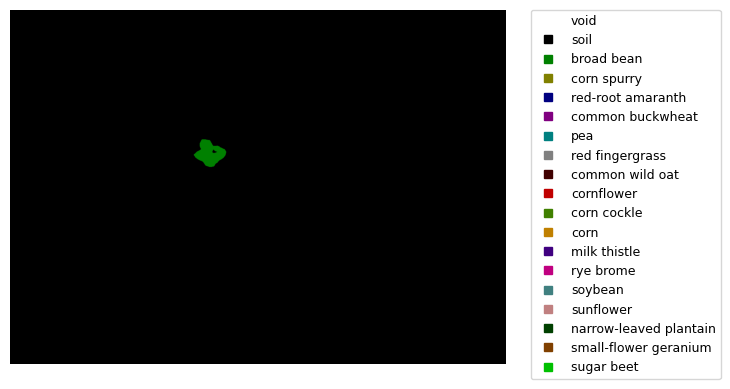

In [12]:
rgb = np.zeros((*im.shape, 3), dtype=np.uint8)
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        index = im[i, j]
        rgb[i, j] = color_values[index]

plt.axis('off')
plt.legend(handles=get_legend(plant_classification, hex_colors), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=9)
plt.imshow(rgb)
plt.show()
# plt.savefig('bsp.png')

In [13]:
# visualize_annotation(pred_seg)

## Oveview model performance

In [32]:
train_runtimes = {}
epochs = {}
train_losses = {}
eval_losses = {}

for model_type in model_types:
    train_runtimes[model_type] = {}
    epochs[model_type] = {}
    train_losses[model_type] = {}
    eval_losses[model_type] = {}

    for crop in crops:
        with open('../models/' + model_type + '/' + crop + '/log_history.json', 'r') as file:
            data = json.load(file)
            
            train_runtimes[model_type][crop] = data[-1]['train_runtime']
            epochs[model_type][crop] = data[-1]['epoch']

            train_losses[model_type][crop] = []
            eval_losses[model_type][crop] = []
            for entry in data:
                if 'eval_loss' in entry.keys():
                    eval_losses[model_type][crop].append(entry['eval_loss'])

                if 'train_loss' in entry.keys():
                    train_losses[model_type][crop].append(entry['train_loss'])

In [33]:
epochs

{'binary': {'broad_bean': 20.0,
  'common_buckwheat': 28.64,
  'pea': 8.87,
  'corn': 8.37,
  'soybean': 3.12,
  'sunflower': 20.31},
 'multiclass': {'broad_bean': 7.5,
  'common_buckwheat': 9.09,
  'pea': 16.9,
  'corn': 19.88,
  'soybean': 4.68,
  'sunflower': 9.69}}

In [34]:
eval_losses

{'binary': {'broad_bean': [1.0664432048797607,
   0.5520932674407959,
   0.4723118245601654,
   0.3307260572910309,
   0.38774341344833374,
   0.1446762979030609,
   0.17110981047153473,
   0.14760535955429077,
   0.11304914951324463,
   0.08016577363014221,
   0.06772596389055252,
   0.09233662486076355,
   0.06825048476457596,
   0.0444728285074234,
   0.054652757942676544,
   0.04777787625789642,
   0.041814181953668594,
   0.038619063794612885,
   0.035982873290777206,
   0.033093683421611786,
   0.03869141638278961,
   0.030978497117757797,
   0.02783055603504181,
   0.02203279361128807,
   0.026799732819199562,
   0.0258265882730484,
   0.021316448226571083,
   0.02363969385623932,
   0.023212598636746407,
   0.019414234906435013,
   0.01871798373758793,
   0.021679336205124855,
   0.023621652275323868,
   0.018220005556941032,
   0.018004558980464935,
   0.018885523080825806,
   0.016688810661435127,
   0.017576346173882484,
   0.015961337834596634,
   0.016599344089627266,
   0

In [22]:
def plot_bar_chart(data):
    # Extract the labels and values for the 'binary' and 'multiclass' categories
    categories = list(data.keys())
    labels = list(data['binary'].keys())
    binary_values = [data['binary'][label] for label in labels]
    multiclass_values = [data['multiclass'][label] for label in labels]

    # Set the width of the bars
    bar_width = 0.35

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create bar positions for each category
    x = range(len(labels))

    # Plot the 'binary' values
    plt.bar(x, binary_values, width=bar_width, label='Binary', align='center')

    # Plot the 'multiclass' values with an offset
    plt.bar([i + bar_width for i in x], multiclass_values, width=bar_width, label='Multiclass', align='center')

    # Set the labels and title
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title('Values for Different Categories and Items')
    plt.xticks([i + bar_width / 2 for i in x], labels, rotation=45)

    # Add a legend
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

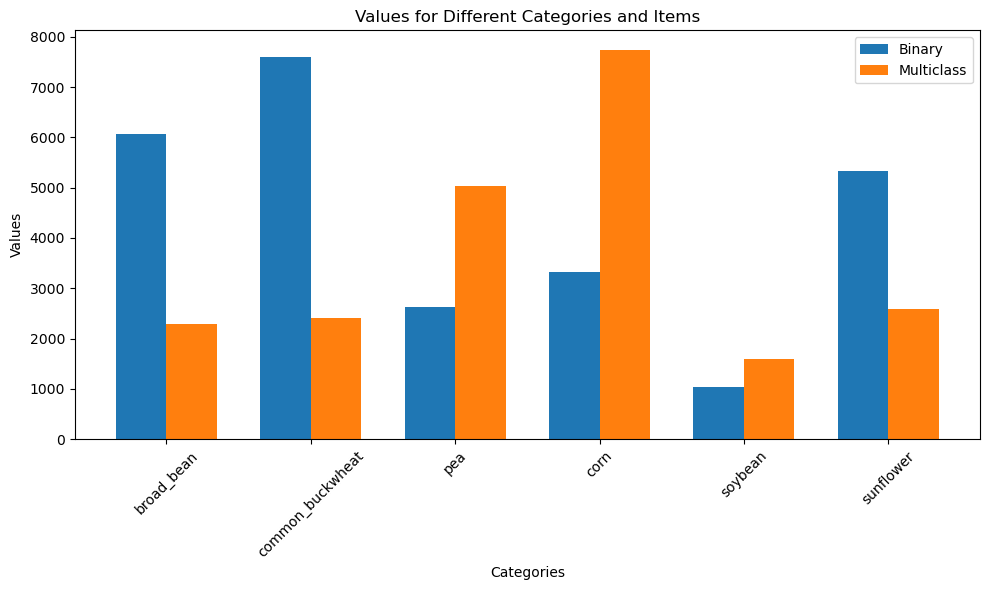

In [24]:
plot_bar_chart(train_runtimes)

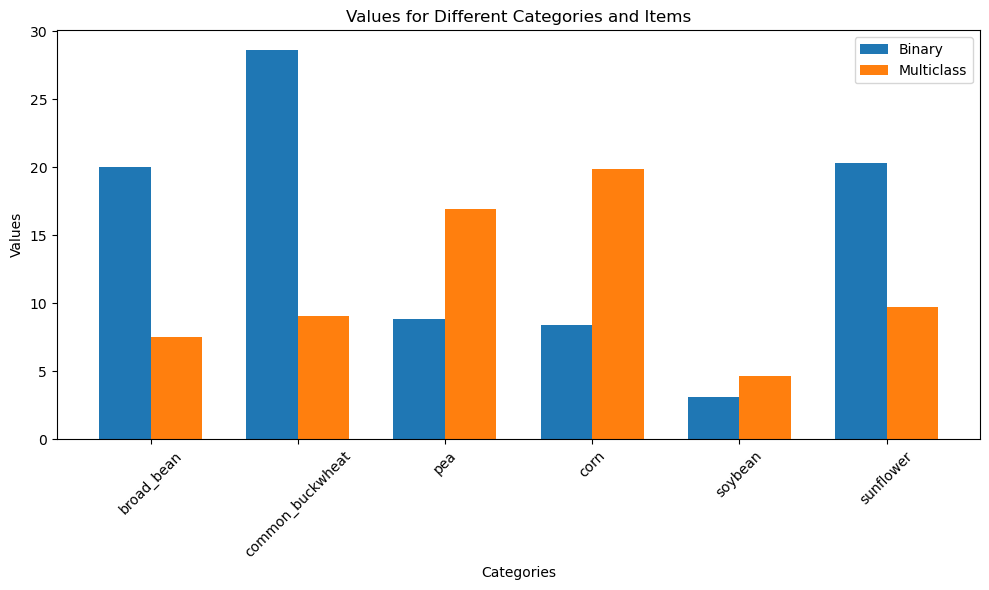

In [25]:
plot_bar_chart(epochs)

In [42]:
def plot_heat_map(data):
    categories = list(data.keys())
    items = list(data['binary'].keys())

    # Convert the data to a NumPy array
    heatmap_data = np.array([[data[category][item] for item in items] for category in categories])

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the heatmap
    cax = ax.matshow(heatmap_data, cmap='viridis')

    # Add colorbar
    cbar = fig.colorbar(cax)

    # Set labels for the x and y axes
    ax.set_xticks(np.arange(len(items)))
    ax.set_yticks(np.arange(len(categories)))
    ax.set_xticklabels(items, rotation=45, ha='right')
    ax.set_yticklabels(categories)

    # Show the values in each cell
    # for i in range(len(categories)):
    #     for j in range(len(items)):
    #         text = ax.text(j, i, f'{heatmap_data[i, j]:.2f}', ha='center', va='center', color='w', fontsize=8)  # Specify fontsize

    # Set a title
    plt.title('Heatmap of Values for Different Categories and Items')

    # Show the plot
    plt.tight_layout()
    plt.show()

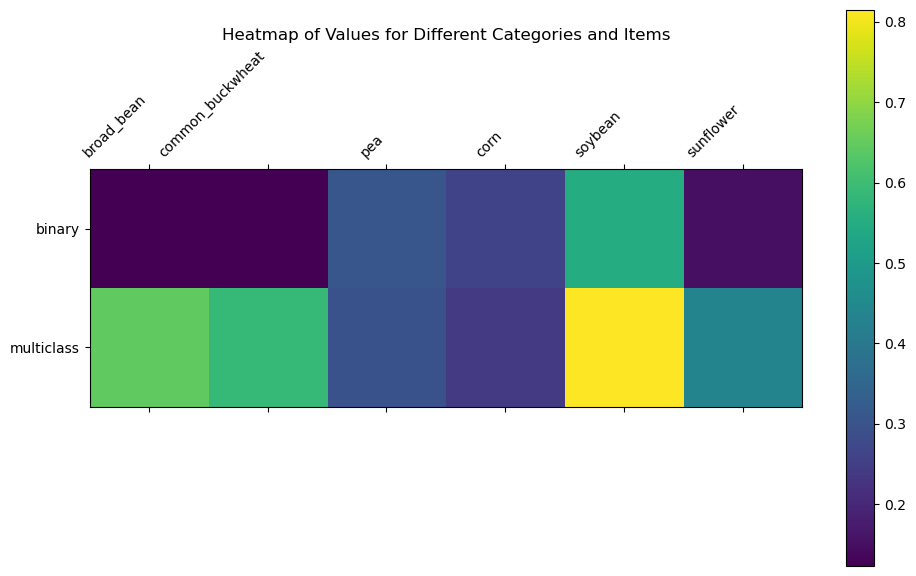

In [43]:
plot_heat_map(train_losses)

In [45]:
def plot_line_graph(data):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Loop through the categories and items to plot lines
    for category, item_data in data.items():
        for item, values in item_data.items():
            label = f'{category} - {item}'  # Construct the label
            x = np.arange(len(values))
            ax.plot(x, values, label=label)

    # Set labels for the x and y axes
    ax.set_xlabel('Data Point')
    ax.set_ylabel('Values')

    # Set a title
    plt.title('Line Graph of Values for Different Categories and Items')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

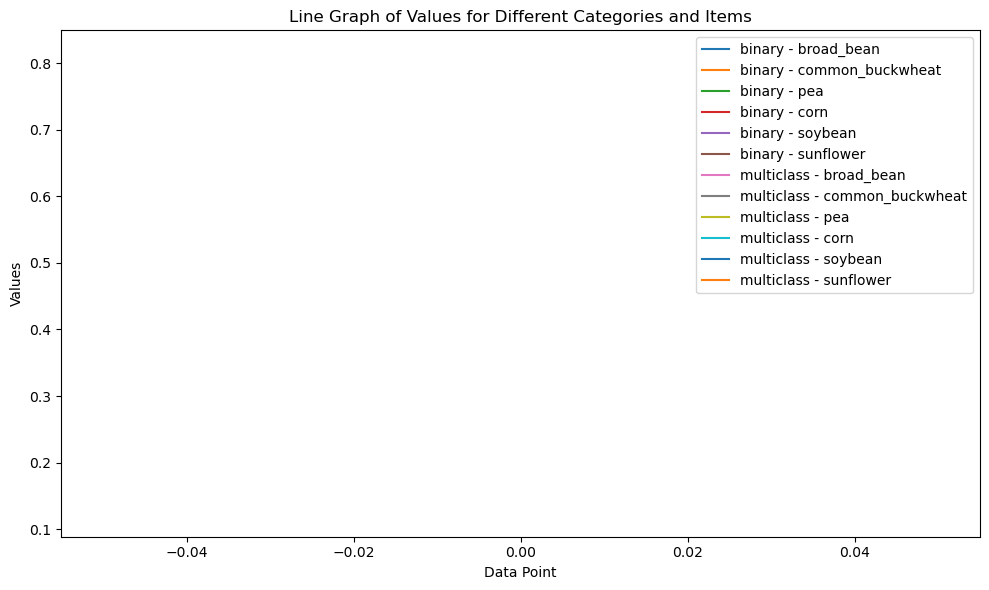

In [47]:
plot_line_graph(train_losses)

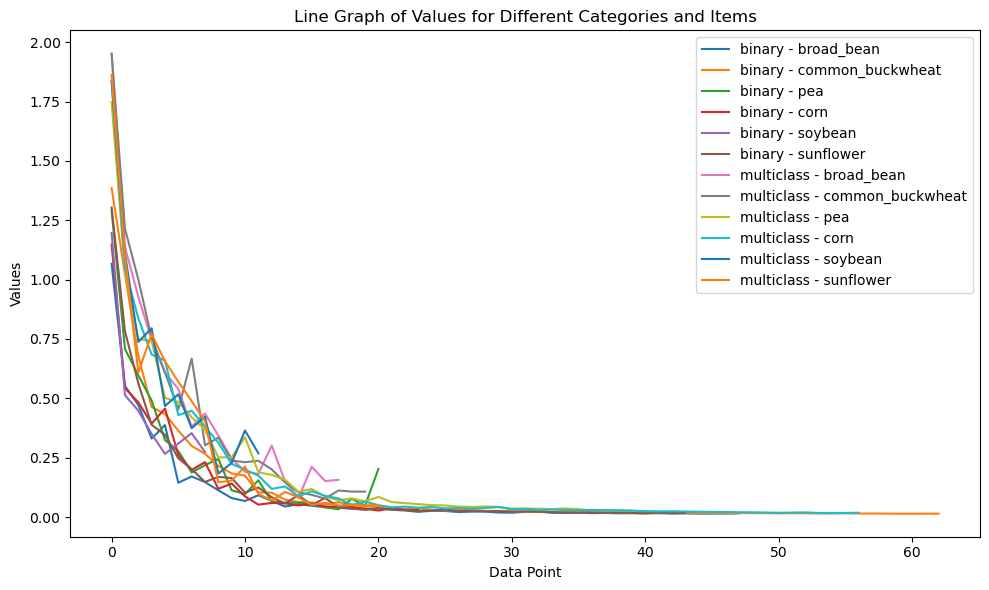

In [48]:
plot_line_graph(eval_losses)